In [1]:
import functions_simple as myfn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import scipy
from scipy import ndimage, io
import dill

In [2]:
% load_ext autoreload
% autoreload 2

In [3]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [5]:
cell_orig = np.load('cell_faceted_2.npy') * 0.5
cell_orig.shape

(28, 58, 62)

In [6]:
np.sum(np.abs(cell_orig) > 0) / (26 * 56 * 60), np.sum(np.abs(cell_orig[1:-1,1:-1,1:-1]) == 0) / (26 * 56 * 60)

(0.38782051282051283, 0.6121794871794872)

In [7]:
simulation_params = np.load('simulation_params.npy')

In [8]:
simulation_params

array({'cell_orig_shape': array([26, 56, 60]), 'cell_padded_shape': (64, 162, 112), 'energy': 8, 'wavelength': 1.54875e-10, 'n_probe_photons': 10000.0, 'det_pixel_pitch': 5.5e-05, 'distance_f_d_ptycho': 1.5, 'probe_yz_npix': 64, 'two_theta_bragg': 1.0471975511965976, 'omega_cen': 0.5235987755982988, 'delta_omega': 0.00034906585039886593, 'number_pos_rc': 15, 'n_det_pix_x': 64, 'n_det_pix_z': 64, 'step_npix_y': 2, 'step_npix_z': 2, 'raster_grid_num_y': 41, 'raster_grid_num_z': 24, 'probe_shape': (64, 80, 64)},
      dtype=object)

In [9]:
cell_padded = np.pad(cell_orig, [[18, 18],[50, 50],[25, 25]], mode='constant')
cell_padded.shape

(64, 158, 112)

In [10]:
nonzero_indices = np.transpose(np.where(np.abs(cell_padded) > 0))
raveled_indices = np.ravel_multi_index(nonzero_indices.T, cell_padded.shape)
nonzero_vals = cell_padded.flatten()[raveled_indices]

nonzero_vals = nonzero_vals * np.exp(-1j * scipy.stats.circmean(np.angle(nonzero_vals)))

cell_padded_temp = np.zeros(cell_padded.size, dtype='complex64')
cell_padded_temp[raveled_indices] = nonzero_vals
cell_padded = cell_padded_temp.reshape(cell_padded.shape)

In [11]:
var_true = np.pad(cell_orig, [[1,1],[10,10],[10,10]], mode='constant')
#obj_init = pr_obj.copy()
var_true.shape

(30, 78, 82)

In [12]:
var_reconstructed =  np.load('reconstructed_faceted_cell_rotated_ki_and_kf_batch_400_stepsize_0.01.npy')
var_padded = np.pad(var_reconstructed, [[18,18], [54,54], [22,22]], mode='constant')
print(var_padded.shape)

recons_nonzero_vals = (np.ravel(var_padded)[raveled_indices])

# Removing the global phase shift
recons_nonzero_vals = recons_nonzero_vals * np.exp(-1j * scipy.stats.circmean(np.angle(recons_nonzero_vals)))
var_reconstructed = var_reconstructed * np.exp(-1j * scipy.stats.circmean(np.angle(recons_nonzero_vals)))
var_padded = var_padded * np.exp(-1j * scipy.stats.circmean(np.angle(recons_nonzero_vals)))

(66, 186, 126)


In [13]:
var_reconstructed[np.abs(var_reconstructed)==0] = 0 + 0j
var_reconstructed = np.roll(var_reconstructed, 1, axis=0)
var_true[np.abs(var_true==0)] = 0 + 0j

In [14]:
io.savemat('cell_true_var', dict(cell_true=var_true))
io.savemat('cell_recons_var', dict(cell_recons=var_reconstructed))

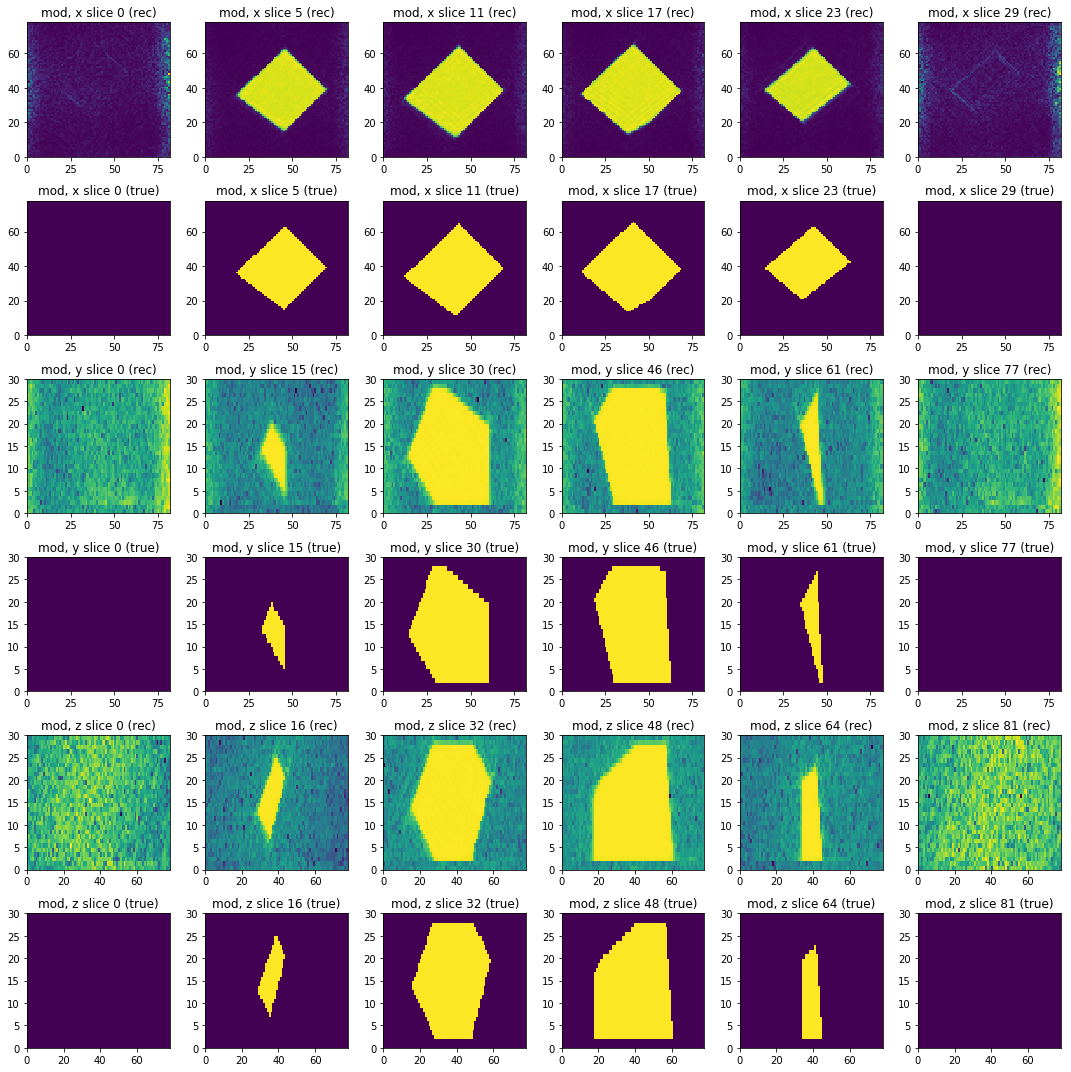

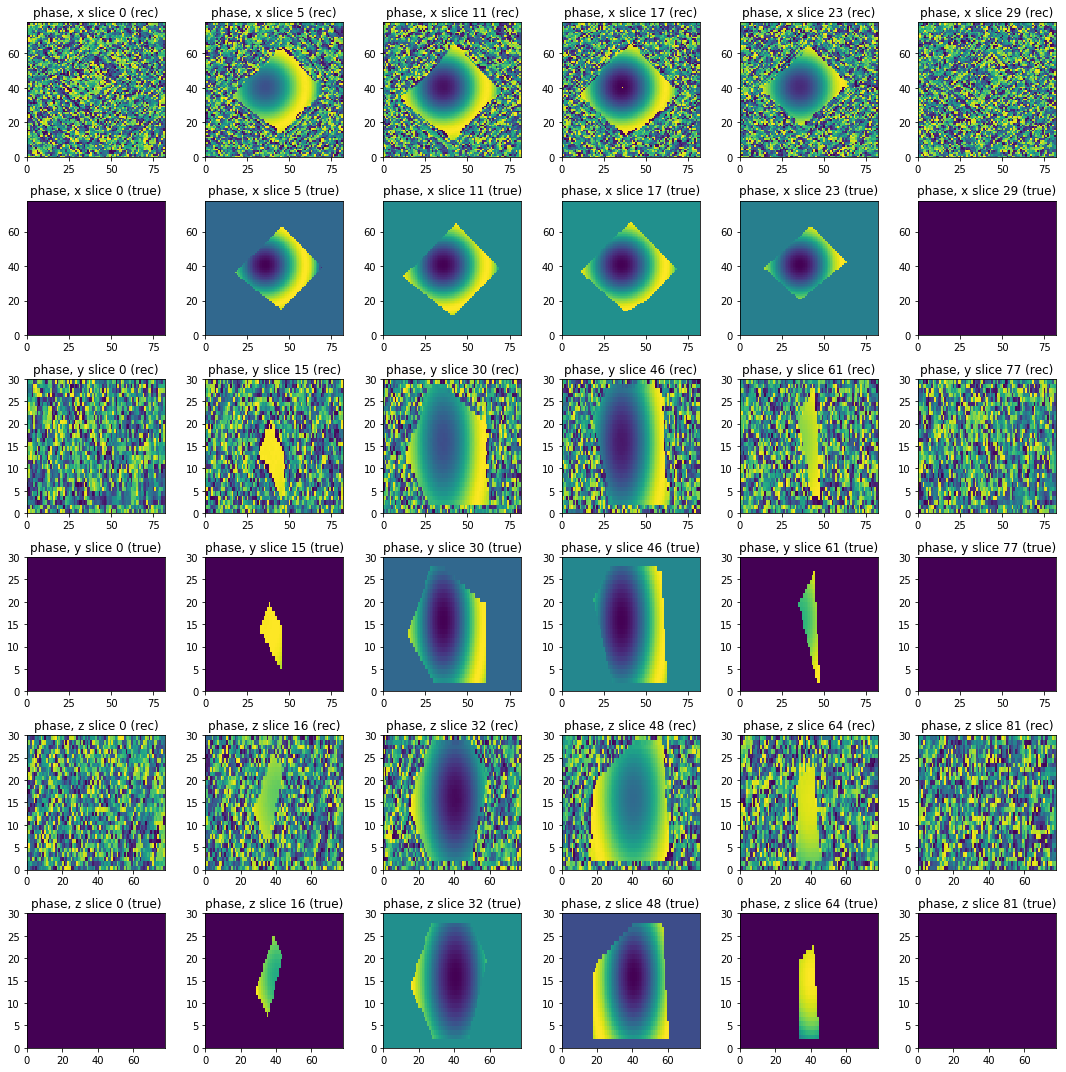

In [15]:
x_slices = np.linspace(0, var_true.shape[0] - 1, 6).astype('int')
y_slices = np.linspace(0, var_true.shape[1] - 1, 6).astype('int')
z_slices = np.linspace(0, var_true.shape[2] - 1, 6).astype('int')

figsize_r = np.max([x_slices.size, y_slices.size, z_slices.size])
plt.figure(figsize=[figsize_r * 2.5, 6 * 2.5])

for indx, x_slice in enumerate(x_slices):
    plt.subplot(6, figsize_r, indx+1)
    plt.pcolormesh(np.abs(var_reconstructed[x_slice, :, :]), rasterized=True)
    plt.title(f'mod, x slice {x_slice} (rec)')
    plt.subplot(6, figsize_r, figsize_r + indx +1)
    plt.pcolormesh(np.abs(var_true[x_slice, :, :]) , rasterized=True)
    plt.title(f'mod, x slice {x_slice} (true)')
    
for indx, y_slice in enumerate(y_slices):
    plt.subplot(6, figsize_r, 2* figsize_r + indx+1)
    plt.pcolormesh(np.log(np.abs(var_reconstructed[:,y_slice, :]) + 1e-12), rasterized=True)
    plt.title(f'mod, y slice {y_slice} (rec)')
    plt.subplot(6, figsize_r, 3 * figsize_r + indx +1)
    plt.pcolormesh(np.abs(var_true[:,y_slice, :]), rasterized=True)
    plt.title(f'mod, y slice {y_slice} (true)')
    
for indx, z_slice in enumerate(z_slices):
    plt.subplot(6, figsize_r, 4* figsize_r + indx+1)
    plt.pcolormesh(np.log(np.abs(var_reconstructed[:,:,z_slice]) + 1e-12), rasterized=True)
    plt.title(f'mod, z slice {z_slice} (rec)')
    plt.subplot(6, figsize_r, 5 * figsize_r + indx +1)
    plt.pcolormesh(np.abs(var_true[:,:,z_slice]), rasterized=True)
    plt.title(f'mod, z slice {z_slice} (true)')

plt.tight_layout()
plt.show()

plt.figure(figsize=[figsize_r * 2.5, 6 * 2.5])
for indx, x_slice in enumerate(x_slices):
    plt.subplot(6, figsize_r, indx+1)
    plt.pcolormesh(np.angle(var_reconstructed[x_slice, :, :]), rasterized=True)
    plt.title(f'phase, x slice {x_slice} (rec)')
    plt.subplot(6, figsize_r, figsize_r + indx +1)
    plt.pcolormesh(np.angle(var_true[x_slice, :, :]), rasterized=True)
    plt.title(f'phase, x slice {x_slice} (true)')
    
for indx, y_slice in enumerate(y_slices):
    plt.subplot(6, figsize_r, 2* figsize_r + indx+1)
    plt.pcolormesh(np.angle(var_reconstructed[:,y_slice, :]), rasterized=True)
    plt.title(f'phase, y slice {y_slice} (rec)')
    plt.subplot(6, figsize_r, 3 * figsize_r + indx +1)
    plt.pcolormesh(np.angle(var_true[:,y_slice, :]), rasterized=True)
    plt.title(f'phase, y slice {y_slice} (true)')
    
for indx, z_slice in enumerate(z_slices):
    plt.subplot(6, figsize_r, 4* figsize_r + indx+1)
    plt.pcolormesh(np.angle(var_reconstructed[:,:,z_slice]), rasterized=True)
    plt.title(f'phase, z slice {z_slice} (rec)')
    plt.subplot(6, figsize_r, 5 * figsize_r + indx +1)
    plt.pcolormesh(np.angle(var_true[:,:,z_slice]), rasterized=True)
    plt.title(f'phase, z slice {z_slice} (true)')

plt.tight_layout()
plt.show()

In [16]:
slice_indx = np.array(var_true.shape) // 2
slice_indx[:,None] * np.identity(3)

array([[15.,  0.,  0.],
       [ 0., 39.,  0.],
       [ 0.,  0., 41.]])

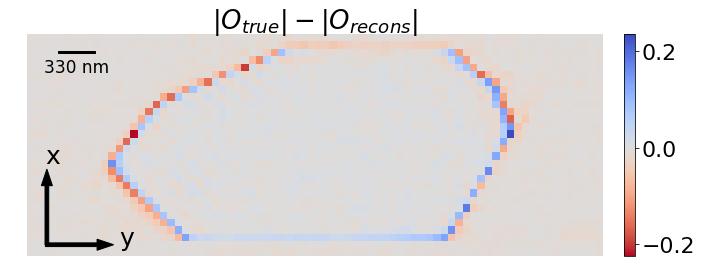

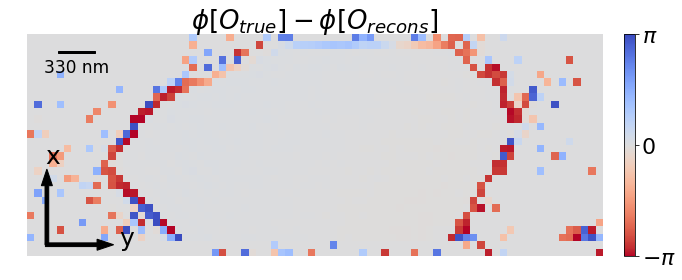

In [47]:
slice_indx = np.array(var_true.shape) // 2
axes = ['x', 'y', 'z']
for indx, s in enumerate(slice_indx):
    if indx < 2: continue
    if indx == 0:
        x1 = var_true[s, :, :]
        x2 = var_reconstructed[s, :, :]
    elif indx == 1:
        x1 = var_true[:, s, :]
        x2 = var_reconstructed[:, s, :]
    else:
        x1 = var_true[:, :, s]
        x2 = var_reconstructed[:, :, s]
    
    Z1 = np.abs(x1) - np.abs(x2)
    #Z1 = np.abs(x1 - x2)
    Z2 = np.angle(np.exp(1j * (np.angle(x1) - np.angle(x2))))
        
    #Z2[x1 == 0] = 0
    

    #abs_title = r'$\left(\lVert O_{true}\rVert -\lVert O_{recons}\rVert\right)$'
    abs_title = r'$\|O_{true}\| - \|O_{recons}\|$'
    phase_title = r'$\phi[O_{true}]-\phi[O_{recons}]$'
    
    norm = MidpointNormalize(midpoint=0)
    
    save_plots = True
    
    if save_plots:
        fig = plt.figure(figsize=[15,4])
    else:
        fig = plt.figure(figsize=[15,4])
    ax = plt.subplot(1,1,1)
    #cax = plt.pcolormesh(Z1, cmap='coolwarm', norm=norm, rasterized=True )#, vmin=min(Z1.min(), -0.1), vmax=max(Z1.max(),0.1), cmap='seismic', rasterized=True)
    cax = plt.imshow(Z1[::-1], cmap='coolwarm_r', norm=norm, vmin=Z1.min(), vmax=Z1.max())
    cax.axes.set_axis_off()
    plt.title(abs_title, fontsize=26)
    cb = plt.colorbar(ticks=[-0.2, 0, 0.2], pad=0.02)
    cb.ax.tick_params(labelsize=22)
    
    fontprops = fm.FontProperties(size=17)
    bar = AnchoredSizeBar(ax.transData, 5, '330 nm', 
                          2, pad=0.5, sep=5, borderpad=0.5, 
                          size_vertical=.25, frameon=False,
                          fontproperties=fontprops)
    bar.size_bar.set_height(5)
    ax.add_artist(bar)
    
    plt.arrow(2,28,7,0,width=0.5,linewidth=None,facecolor='black')
    plt.arrow(2.2,28,0,-8,width=0.5,linewidth=None,facecolor='black')
    plt.text(12,28,'y',fontsize=25,color='black')
    plt.text(2,17,'x',fontsize=25,color='black')
    ax.set_aspect('equal')
    plt.tight_layout()
    if save_plots:
        plt.savefig('multi_angle_recons_cross_section_differences_abs_{axis}.pdf'.format(axis=axes[indx]), bbox_inches='tight')
    plt.show()

    
    Z2[np.abs(x2)<.01] = 0
    
    #cmap = plt.cm.YlOrRd
    cmap = plt.cm.coolwarm_r
    normalized_angles = MidpointNormalize(vmin=-np.pi, midpoint=0, vmax=np.pi)(Z2[::-1])
    colors = cmap(normalized_angles)

    alphas = Normalize(vmin=0,vmax=np.abs(Z1).max(),clip=True)(np.abs(Z1[::-1]))
    colors[...,-1] = 1#alphas

    greys = np.empty(alphas.shape + (3,), dtype=np.uint8)
    greys.fill(0)
    
    
    if save_plots:
        fig = plt.figure(figsize=[15,4])
    else:
        fig = plt.figure(figsize=[15,4])
    
    ax = plt.subplot(1,1,1)
    
    plt.imshow(greys, aspect='equal')
    plt.imshow(colors, aspect='equal', vmin=-np.pi, vmax=np.pi, cmap=cmap, interpolation=None)
    ax.set_axis_off()
    cb = plt.colorbar(pad=0.02, ticks=[-np.pi, 0, np.pi])#, orientation='vertical',aspect=30)
    
    fontprops = fm.FontProperties(size=17)
    bar = AnchoredSizeBar(ax.transData, 5, '330 nm', 
                          2, pad=0.5, sep=5, borderpad=0.5, 
                          size_vertical=.25, frameon=False,
                          fontproperties=fontprops)
    bar.size_bar.set_height(5)
    ax.add_artist(bar)
    
    plt.title(phase_title, fontsize=26)
    cb.ax.tick_params(labelsize=22) 
    cb.ax.set_yticklabels([r'$-\pi$', r'0', r'$\pi$'])
    plt.arrow(2,28,7,0,width=0.5,linewidth=None,facecolor='black')
    plt.arrow(2.2,28,0,-8,width=0.5,linewidth=None,facecolor='black')
    
    plt.text(12,28,'y',fontsize=25,color='black')
    plt.text(2,17,'x',fontsize=25,color='black')
    ax.set_aspect('equal')
    plt.tight_layout()
    if save_plots:
        plt.savefig('multi_angle_recons_cross_section_differences_phase_{axis}.pdf'.format(axis=axes[indx]), bbox_inches='tight')
    plt.show()

In [29]:
two_theta_bragg = 60 * np.pi/180
probe = np.load('probe_gaussian_fwhm_6_speckle_20_yz.npy')
probe_3d = np.repeat(probe[None, :,:], 111, axis=0)

rotate_angle = (np.pi/2 - two_theta_bragg) * 180 / np.pi
rotate_fn = lambda x: ndimage.rotate(x, rotate_angle, axes=(0,1), mode='constant', order=1)
probe_rotated = rotate_fn(np.real(probe_3d)) + 1j * rotate_fn(np.imag(probe_3d))
probe_rotated_centered = probe_rotated[32:96,16:96]

In [30]:
new_cmap = truncate_colormap(plt.get_cmap('coolwarm'), minval=0.5, maxval=1)

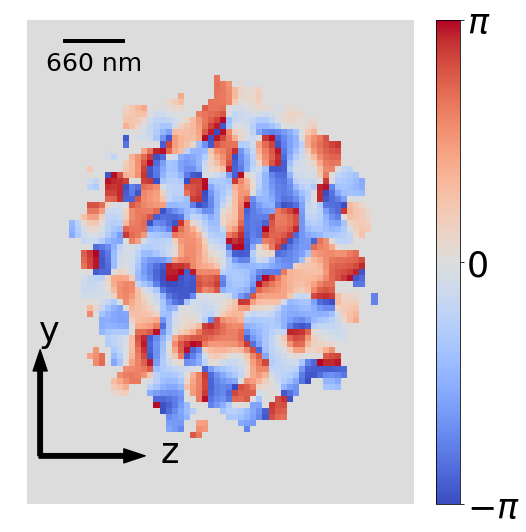

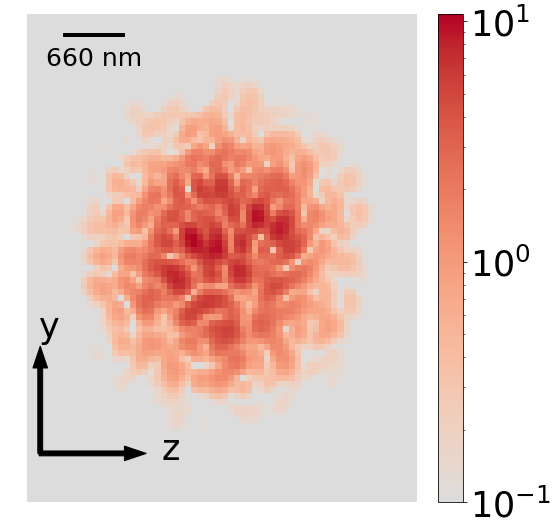

In [48]:
probe_image = probe_rotated_centered[32]
absvals = np.abs(probe_image)
angvals = np.angle(probe_image)
angvals[absvals < 0.1] = 0
absvals[absvals<0.1] = 0.1

plt.figure(figsize=[15,7.5])
ax = plt.subplot(1,1,1)
ax.set_axis_off()

cax = plt.pcolormesh(angvals, cmap='coolwarm',
                     norm=MidpointNormalize(vmin=-np.pi, vmax=np.pi, midpoint=0))
cb = plt.colorbar(pad=0.02, ticks=[-np.pi, 0, np.pi])
cb.ax.set_yticklabels([r'$-\pi$', r'0', r'$\pi$'])
cb.ax.tick_params(labelsize=35)

fontprops = fm.FontProperties(size=25)
bar = AnchoredSizeBar(ax.transData, 10, '660 nm', 
                      2, pad=0.25, sep=10, borderpad=0.5, 
                      size_vertical=.5, frameon=False,
                      fontproperties=fontprops)
ax.add_artist(bar)


plt.arrow(2,8,14,0,width=0.8,linewidth=None,facecolor='black')
plt.arrow(2.2,8,0,14,width=0.8,linewidth=None,facecolor='black')
plt.text(22,7,'z',fontsize=35,color='black')
plt.text(2,27,'y',fontsize=35,color='black')
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('gaussian_speckle_probe_phase.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=[15,7.5])
ax = plt.subplot(1,1,1)
ax.set_axis_off()
cax = plt.pcolormesh(absvals, cmap=new_cmap,
                     norm=LogNorm(vmin=0.1, vmax=absvals.max()))
cb = plt.colorbar(cax, pad=0.02, ticks=[0.1, 1, 10])
#cb.ax.set_yticklabels([-2, -1, 0, 1])
cb.ax.tick_params(labelsize=35)

fontprops = fm.FontProperties(size=25)
bar = AnchoredSizeBar(ax.transData, 10, '660 nm', 
                      2, pad=0.25, sep=10, borderpad=0.5, 
                      size_vertical=.5, frameon=False,
                      fontproperties=fontprops)
ax.add_artist(bar)

plt.arrow(2,8,14,0,width=0.8,linewidth=None,facecolor='black')
plt.arrow(2.2,8,0,14,width=0.8,linewidth=None,facecolor='black')
plt.text(22,7,'z',fontsize=35,color='black')
plt.text(2,27,'y',fontsize=35,color='black')
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('gaussian_speckle_probe_abs.pdf', bbox_inches='tight')
plt.show()

In [250]:
io.savemat('recons_nonzero_only_padded', dict(recons_nonzero_only_padded=recons_nonzero_only_padded))

In [253]:
nonzero_var_indices = np.transpose(np.where(np.abs(var_true) > 0))
var_raveled_indices = np.ravel_multi_index(nonzero_var_indices.T, var_true.shape)
recons_var_nonzero_vals = var_reconstructed.flatten()[var_raveled_indices]

recons_var_nonzero_only = np.zeros_like(var_true).flatten()
recons_var_nonzero_only[var_raveled_indices] = recons_var_nonzero_vals
recons_var_nonzero_only = recons_var_nonzero_only.reshape(var_reconstructed.shape)

In [254]:
cell_new = cell_padded.copy()
cell_new_temp = []
for i in range(cell_new.shape[0]):
    if not (cell_new[i] == 0).all():
        cell_new_temp.append(cell_new[i])
cell_new = np.transpose(np.array(cell_new_temp), axes=(1, 0, 2))

cell_new_temp = []
for i in range(cell_new.shape[0]):
    if not (cell_new[i] == 0).all():
        cell_new_temp.append(cell_new[i])
cell_new = np.transpose(np.array(cell_new_temp), axes=(2, 1, 0))

cell_new_temp = []
for i in range(cell_new.shape[0]):
    if not (cell_new[i] == 0).all():
        cell_new_temp.append(cell_new[i])
cell_new = np.array(cell_new_temp)
cell_new = np.pad(cell_new, [[1,1 + cell_new.shape[0] % 2],
                             [1,1 + cell_new.shape[1] % 2],
                             [1,1 + cell_new.shape[2] % 2]], mode='constant')
io.savemat('cell_trimmed', dict(cell_padded=cell_new))

In [255]:
cell_new = recons_nonzero_only_padded.copy()
cell_new_temp = []
for i in range(cell_new.shape[0]):
    if not (cell_new[i] == 0).all():
        cell_new_temp.append(cell_new[i])
cell_new = np.transpose(np.array(cell_new_temp), axes=(1, 0, 2))

cell_new_temp = []
for i in range(cell_new.shape[0]):
    if not (cell_new[i] == 0).all():
        cell_new_temp.append(cell_new[i])
cell_new = np.transpose(np.array(cell_new_temp), axes=(2, 1, 0))

cell_new_temp = []
for i in range(cell_new.shape[0]):
    if not (cell_new[i] == 0).all():
        cell_new_temp.append(cell_new[i])
cell_new = np.array(cell_new_temp)
cell_new = np.pad(cell_new, [[1,1 + cell_new.shape[0] % 2],
                             [1,1 + cell_new.shape[1] % 2],
                             [1,1 + cell_new.shape[2] % 2]], mode='constant')
io.savemat('recons_cell_trimmed', dict(cell_padded=cell_new))